# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency
from scipy.stats import skew

import os

# Preprocessing
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer


# metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# ML algorithms
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


# saving model
import joblib


# Helper Functions

In [8]:
!wget https://raw.githubusercontent.com/ezzaddeentru/recipe-popularity-prediction/main/helper_functions.py

--2024-08-19 22:49:20--  https://raw.githubusercontent.com/ezzaddeentru/recipe-popularity-prediction/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43593 (43K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  42.57K  --.-KB/s    in 0.008s  

2024-08-19 22:49:21 (5.00 MB/s) - ‘helper_functions.py’ saved [43593/43593]



In [9]:
from helper_functions import *
from helper_functions import plot_confusion_matrix, plot_model_metrics_with_size
from helper_functions import plot_metrics_with_plotly, plot_feature_importance, plot_learning_curves
from helper_functions import evaluate_and_plot_base_model_clf
from helper_functions import classification_metrics_df, combine_and_format_metrics, calculate_cv_metrics

from helper_functions import chi_square_test, chi2_feature_selection, anova_feature_selection

from helper_functions import plot_feature_distributions, plot_numerical_features, plot_category_distribution
from helper_functions import plot_category_distribution_by_group, plot_numerical_feature_comparison

# Frame the problem
The telecommunications (telecom) sector in India is rapidly changing, with more and more telecom businesses being created and many customers deciding to switch between providers. "Churn" refers to the process where customers or subscribers stop using a company's services or products. Understanding the factors that influence keeping a customer as a client in predicting churn is crucial for telecom companies to enhance their service quality and customer satisfaction. As the data scientist on this project, you aim to explore the intricate dynamics of customer behavior and demographics in the Indian telecom sector in predicting customer churn, utilizing two comprehensive datasets from four major telecom partners: Airtel, Reliance Jio, Vodafone, and BSNL.

# Data

- `telecom_demographics.csv` contains information related to Indian customer demographics:

| Variable             | Description                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Unique identifier for each customer.             |
| `telecom_partner `     | The telecom partner associated with the customer.|
| `gender `              | The gender of the customer.                      |
| `age `                 | The age of the customer.                         |
| `state`                | The Indian state in which the customer is located.|
| `city`                 | The city in which the customer is located.       |
| `pincode`              | The pincode of the customer's location.          |
| `registration_event` | When the customer registered with the telecom partner.|
| `num_dependents`      | The number of dependents (e.g., children) the customer has.|
| `estimated_salary`     | The customer's estimated salary.                 |

- `telecom_usage` contains information about the usage patterns of Indian customers:

| Variable   | Description                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Unique identifier for each customer.                         |
| `calls_made` | The number of calls made by the customer.                    |
| `sms_sent`   | The number of SMS messages sent by the customer.             |
| `data_used`  | The amount of data used by the customer.                     |
| `churn`    | Binary variable indicating whether the customer has churned or not (1 = churned, 0 = not churned).|

In [2]:
!wget https://raw.githubusercontent.com/ezzaddeentru/churn-prediction/main/telecom_demographics.csv
!wget https://raw.githubusercontent.com/ezzaddeentru/churn-prediction/main/telecom_usage.csv

--2024-08-19 22:43:56--  https://raw.githubusercontent.com/ezzaddeentru/churn-prediction/main/telecom_demographics.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420614 (411K) [text/plain]
Saving to: ‘telecom_demographics.csv’

telecom_demographic 100%[===================>] 410.76K  --.-KB/s    in 0.03s   

2024-08-19 22:43:56 (12.2 MB/s) - ‘telecom_demographics.csv’ saved [420614/420614]

--2024-08-19 22:43:56--  https://raw.githubusercontent.com/ezzaddeentru/churn-prediction/main/telecom_usage.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting respo

In [3]:
telecom_demographics = pd.read_csv('telecom_demographics.csv')
telecom_usage = pd.read_csv('telecom_usage.csv')

In [4]:
telecom_demographics.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157


In [5]:
telecom_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         6500 non-null   int64 
 1   telecom_partner     6500 non-null   object
 2   gender              6500 non-null   object
 3   age                 6500 non-null   int64 
 4   state               6500 non-null   object
 5   city                6500 non-null   object
 6   pincode             6500 non-null   int64 
 7   registration_event  6500 non-null   object
 8   num_dependents      6500 non-null   int64 
 9   estimated_salary    6500 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 507.9+ KB


In [10]:
telecom_usage.head()

,customer_id,calls_made,sms_sent,data_used,churn
0,15169,75,21,4532,1
1,149207,35,38,723,1
2,148119,70,47,4688,1
3,187288,95,32,10241,1
4,14016,66,23,5246,1


In [8]:
telecom_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   customer_id  6500 non-null   int64
 1   calls_made   6500 non-null   int64
 2   sms_sent     6500 non-null   int64
 3   data_used    6500 non-null   int64
 4   churn        6500 non-null   int64
dtypes: int64(5)
memory usage: 254.0 KB


In [6]:
# Merge the two datasets on the 'customerID' column
df = pd.merge(telecom_demographics, telecom_usage, on='customer_id')
df.head()


,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         6500 non-null   int64 
 1   telecom_partner     6500 non-null   object
 2   gender              6500 non-null   object
 3   age                 6500 non-null   int64 
 4   state               6500 non-null   object
 5   city                6500 non-null   object
 6   pincode             6500 non-null   int64 
 7   registration_event  6500 non-null   object
 8   num_dependents      6500 non-null   int64 
 9   estimated_salary    6500 non-null   int64 
 10  calls_made          6500 non-null   int64 
 11  sms_sent            6500 non-null   int64 
 12  data_used           6500 non-null   int64 
 13  churn               6500 non-null   int64 
dtypes: int64(9), object(5)
memory usage: 711.1+ KB


- Data is clean so no need for data validation or data cleaning.

# EDA

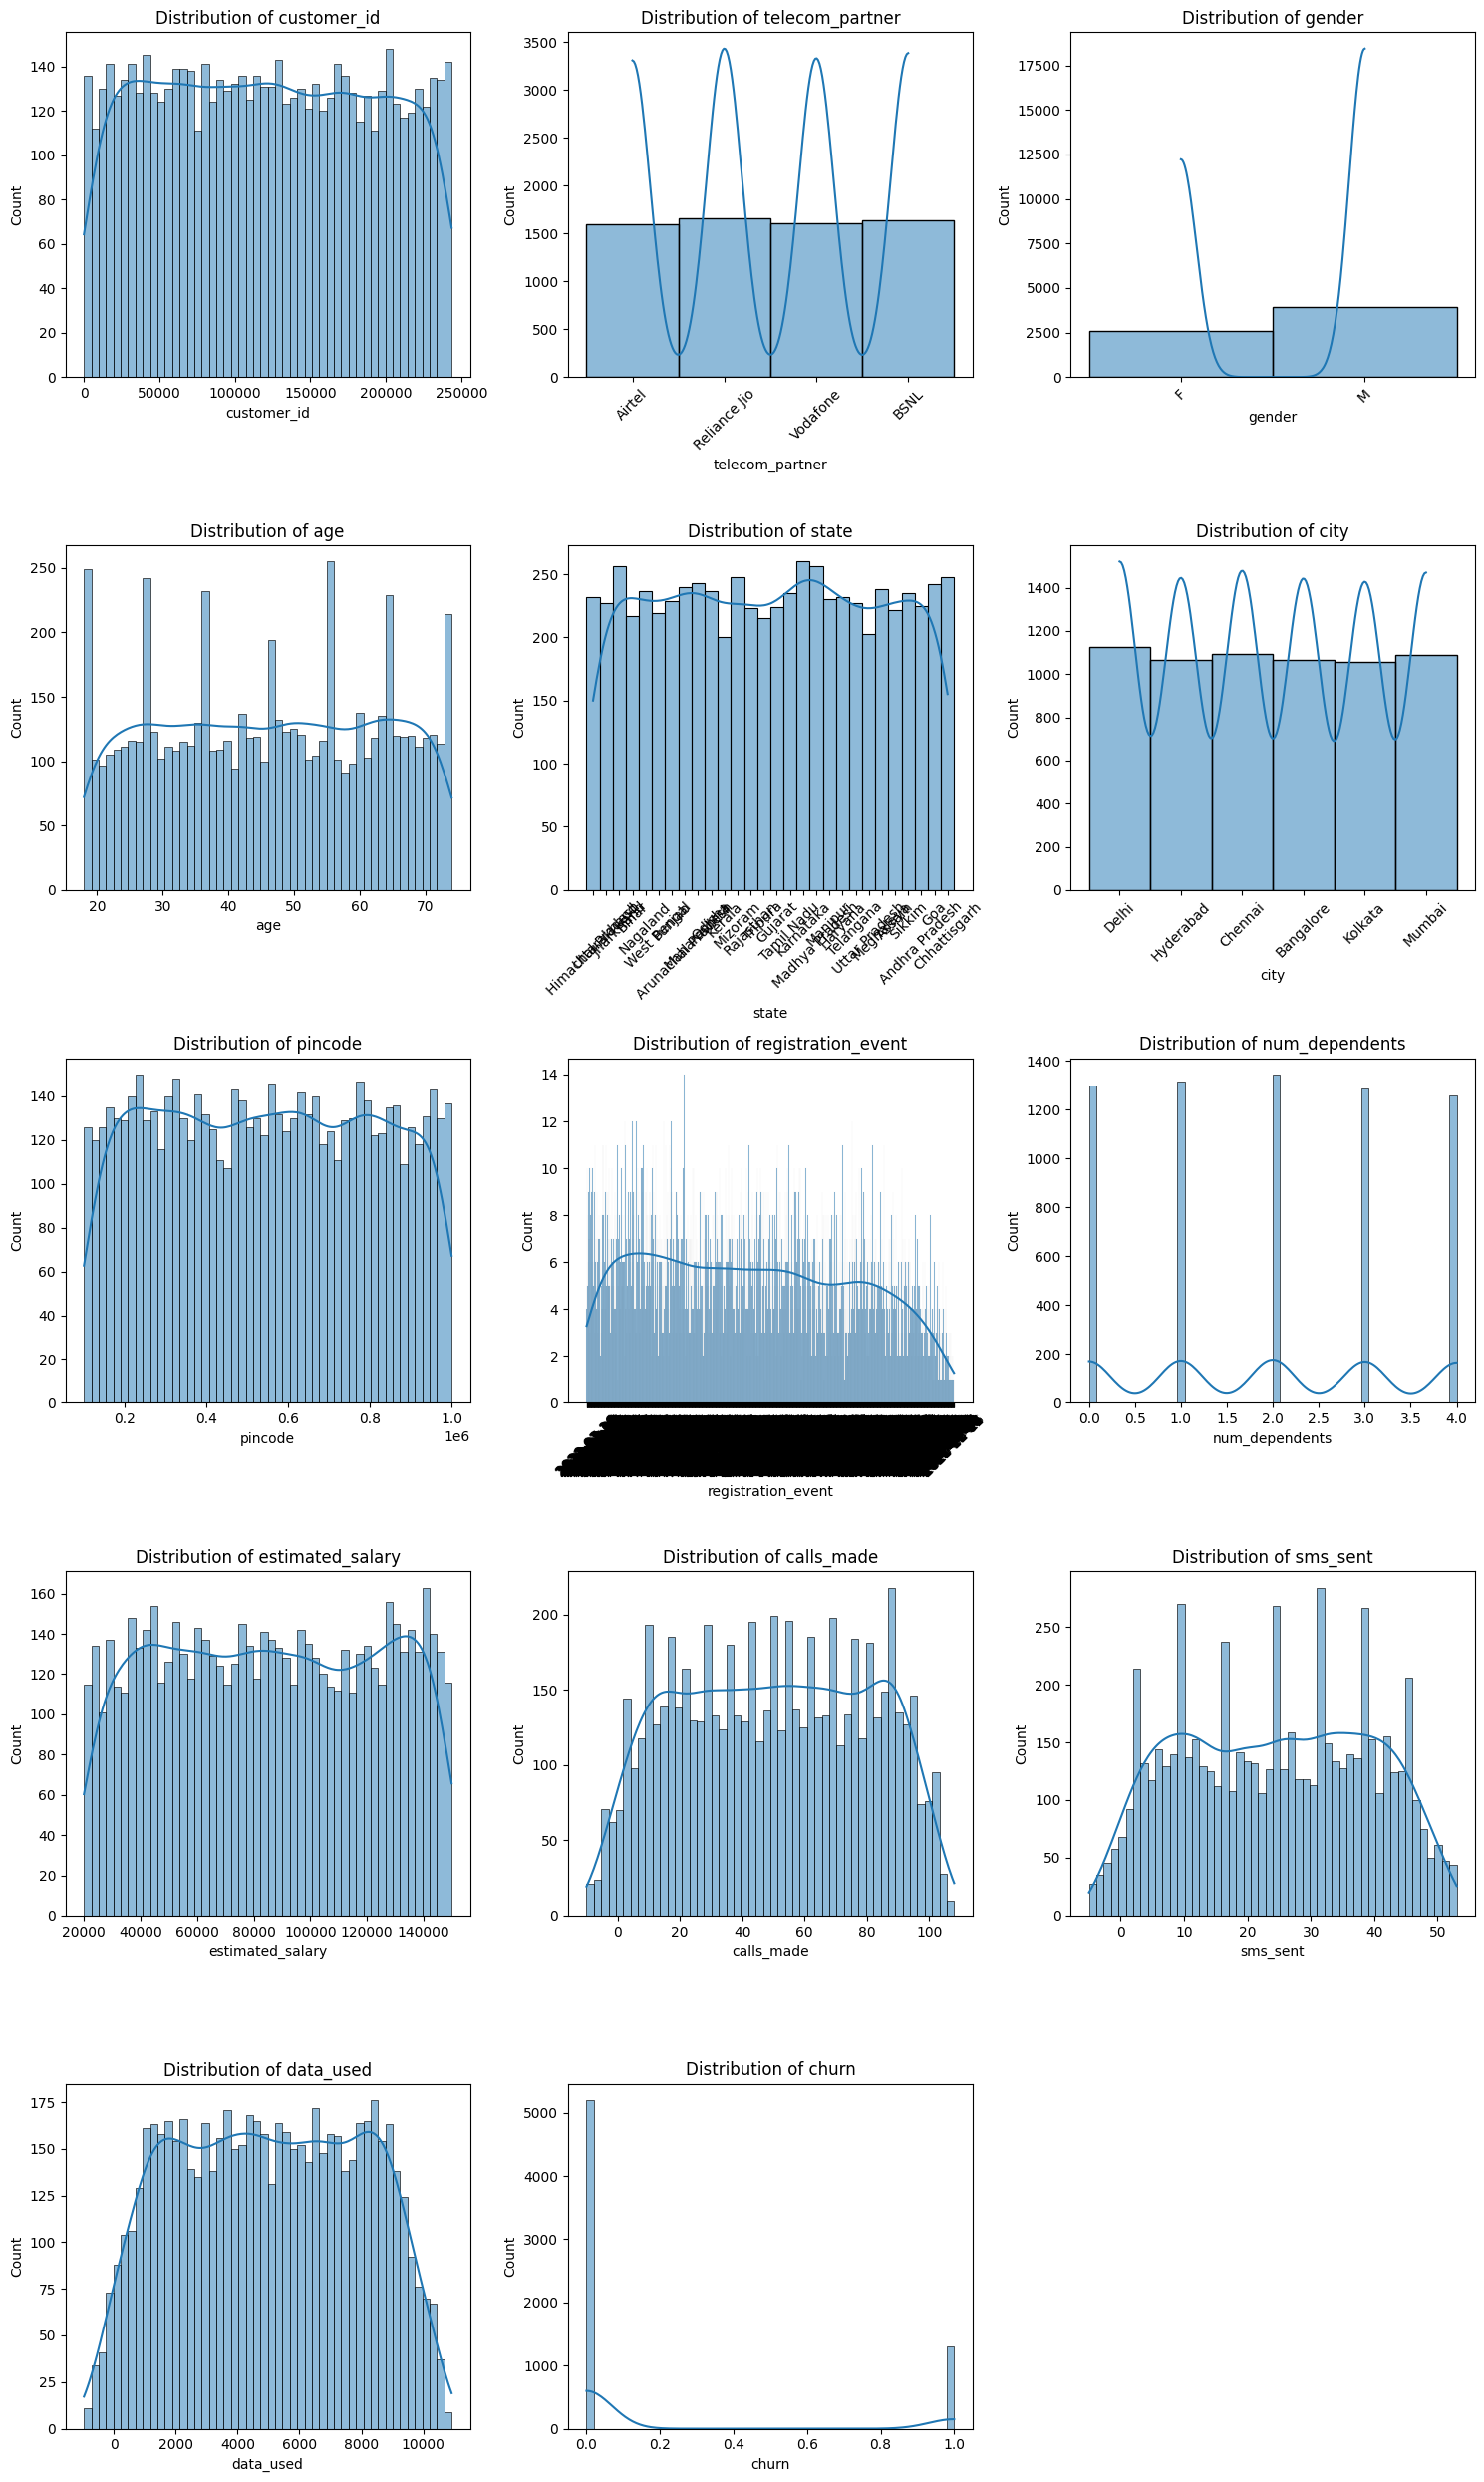

In [10]:
plot_feature_distributions(df)

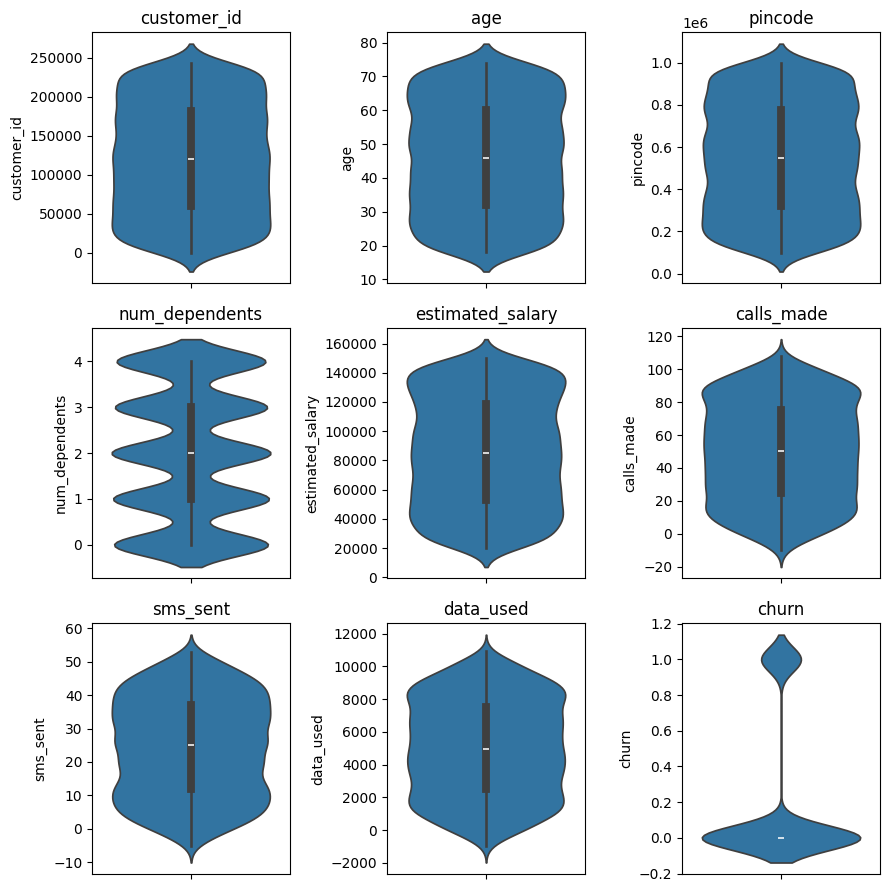

In [16]:
plot_numerical_features(df, plot_type='violinplot')

In [18]:
plot_category_distribution(df, 'gender')

In [19]:
plot_category_distribution(df, 'telecom_partner')

In [20]:
plot_category_distribution(df, 'state')

In [21]:
plot_category_distribution(df, 'city')

In [24]:
plot_category_distribution_by_group(df, 'telecom_partner', 'gender')

In [26]:
plot_category_distribution_by_group(df, 'telecom_partner', 'churn')

In [27]:
plot_category_distribution_by_group(df, 'state', 'churn')

In [28]:
plot_category_distribution_by_group(df, 'city', 'churn')

In [30]:
import plotly.express as px
import plotly.io as pio

def plot_category_distribution_by_group_1(df, category_column, target_column):
    # Create the plot
    fig = px.histogram(df, x=category_column, color=target_column, barmode='group',
                       title=f'Distribution of {category_column} by {target_column}')

    # Save the plot as a static image
    pio.write_image(fig, "category_distribution.png")

    # Display the image in the notebook
    from IPython.display import Image
    return Image("category_distribution.png")

# Assuming df is your DataFrame
plot_category_distribution_by_group(df, 'city', 'churn')
